# Mask R-CNN - Training

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets
opendatasets.download("https://www.kaggle.com/datasets/dataclusterlabs/indian-sign-board-image-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kkkkkumar
Your Kaggle Key: ··········


100%|██████████| 400M/400M [00:04<00:00, 87.3MB/s]

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

## Configurations

In [ ]:
class SignsConfig(Config):
    # Give the configuration a recognizable name
    NAME = "signs"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STPES = 5

config = SignsConfig()
config.print()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           signs
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         200

In [ ]:
class TrafficSignDataset(tf.keras.utils.Sequence):
    def __init__(self, data, folder, is_train=True, batch_size=32):
        self.data = data
        self.folder = folder
        self.is_train = is_train
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data = self.data[start:end]

        images = []
        masks = []
        class_ids = []

        for entry in batch_data:
            image_path = os.path.join(self.folder, entry["filename"])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if "xmin" in entry and "ymin" in entry and "xmax" in entry and "ymax" in entry:
                bboxes = np.array([[entry["xmin"], entry["ymin"], entry["xmax"], entry["ymax"]]])
                augmented_image, augmented_bboxes = augment_image(image, bboxes)
                resized_image, resized_mask = resize_image_and_mask(augmented_image, np.zeros_like(augmented_image))

                current_masks = np.zeros((resized_mask.shape[0], resized_mask.shape[1], 1), dtype=np.uint8)
                current_class_ids = np.array([[1]])  # Update to a tensor with shape (1, 1, 1, 2)

            images.append(resized_image)
            masks.append(current_masks)
            class_ids.append(current_class_ids)

        images = np.array(images)
        masks = np.array(masks)
        class_ids = np.array(class_ids)

        return images, {"class_output": class_ids, "mask_output": masks}

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


# Set your folder paths
xml_folder = "/content/indian-sign-board-image-dataset/Annotations/Annotations"
img_folder = "/content/indian-sign-board-image-dataset/Batch-1/batch"

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("signs", 1, "road_closed_sign")
#         self.add_class("shapes", 2, "circle")
#         self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
#             bg_color, shapes = self.random_image(height, width)

            number = i + 220
            self.add_image("signs", image_id=i, path="/Users/zhonghengli/Downloads/road closed sign _ Google Search/256x256/" + "road_closed" + str(number) + ".jpeg",
                           maskPath="/Users/zhonghengli/Downloads/road closed sign _ Google Search/256x256/Mask/road_closed" + str(number) + ".jpeg",
                           width=width, height=height)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]

        img = cv2.imread(info['path'])

        image = np.zeros_like(img)
        image[:,:,0] = img[:,:,2]
        image[:,:,1] = img[:,:,1]
        image[:,:,2] = img[:,:,0]

        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        maskImg = cv2.imread(info['maskPath'], 0)

        thresh = 127
        MaskImg_bw = cv2.threshold(maskImg, thresh, 255, cv2.THRESH_BINARY)[1]

        image = cv2.bitwise_not(MaskImg_bw)

        image = image.reshape(256,256,1)

        # Map class names to class IDs.
        class_ids = np.array([1]) # Hard Coded for Class 1

        return image, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            image = cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            image = cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            image = cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [ ]:
# Training dataset
dataset_train = TrafficSignDataset()
dataset_train.load_shapes(30, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])

In [ ]:
dataset_train.image_info[1]

{'height': 256,
 'id': 1,
 'maskPath': '/Users/zhonghengli/Downloads/road closed sign _ Google Search/256x256/Mask/road_closed221.jpeg',
 'path': '/Users/zhonghengli/Downloads/road closed sign _ Google Search/256x256/road_closed221.jpeg',
 'source': 'signs',
 'width': 256}

In [ ]:
# Training dataset
dataset_train = TrafficSignDataset()
dataset_train.load_shapes(30, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = TrafficSignDataset()
dataset_val.load_shapes(8, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

image.shape:  (256, 256, 3)
mask.shape:  (256, 256, 1)


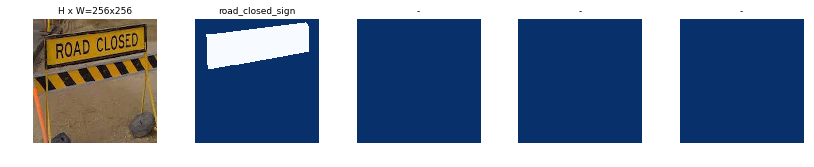

image.shape:  (256, 256, 3)
mask.shape:  (256, 256, 1)


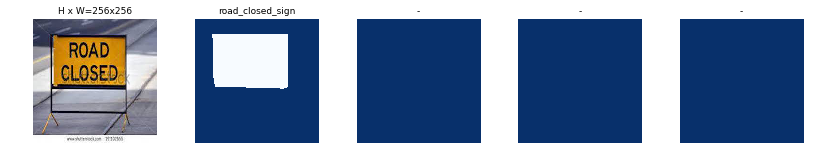

image.shape:  (256, 256, 3)
mask.shape:  (256, 256, 1)


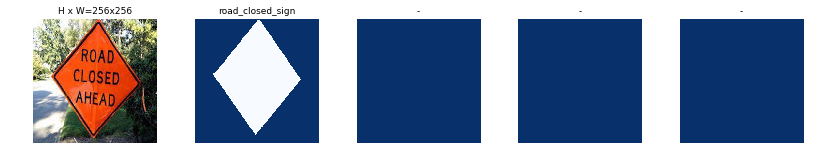

image.shape:  (256, 256, 3)
mask.shape:  (256, 256, 1)


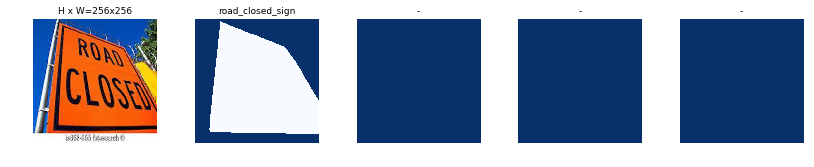

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

    #Check Shapes
    print("image.shape: ", image.shape)
    print("mask.shape: ", mask.shape)

    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")


Starting at epoch 0. LR=0.0002

Checkpoint Path: /Users/zhonghengli/Documents/NYU Autonomous/Mask RCNN/Mask_RCNN/logs/signs20180103T0839/mask_rcnn_signs_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

/Users/zhonghengli/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/zhonghengli/anaconda/lib/python3.5/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/2
100/100 [==============================] - 3289s - loss: 18.7959 - rpn_class_loss: 0.4982 - rpn_bbox_loss: 2.3285 - mrcnn_class_loss: 0.4876 - mrcnn_bbox_loss: 4.9484 - mrcnn_mask_loss: 0.7629 - val_loss: 13.1486 - val_rpn_class_loss: 0.0700 - val_rpn_bbox_loss: 0.5911 - val_mrcnn_class_loss: 0.3933 - val_mrcnn_bbox_loss: 1.5624 - val_mrcnn_mask_loss: 0.7616
Epoch 2/2
100/100 [==============================] - 3167s - loss: 12.4927 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.2030 - mrcnn_class_loss: 0.2810 - mrcnn_bbox_loss: 1.5666 - mrcnn_mask_loss: 0.6323 - val_loss: 12.0163 - val_rpn_class_loss: 0.0273 - val_rpn_bbox_loss: 0.7441 - val_mrcnn_class_loss: 0.1136 - val_mrcnn_bbox_loss: 0.6272 - val_mrcnn_mask_loss: 0.7339


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_sign.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(SignsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/zhonghengli/Documents/NYU Autonomous/Mask RCNN/Mask_RCNN/logs/signs20180103T0839/mask_rcnn_signs_0001.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  256.00000
gt_bbox                  shape: (1, 5)                min:    1.00000  max:  180.00000
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:  255.00000


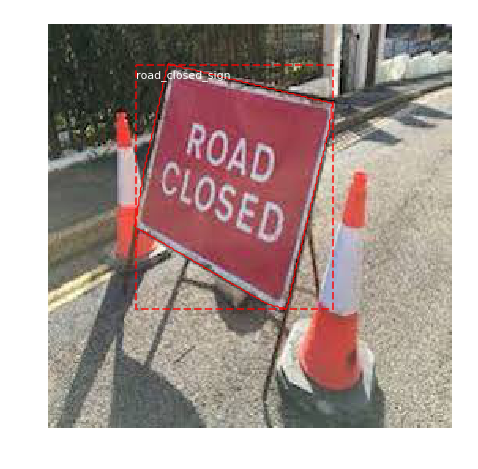

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox[:,:4], gt_mask, gt_bbox[:,4],
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


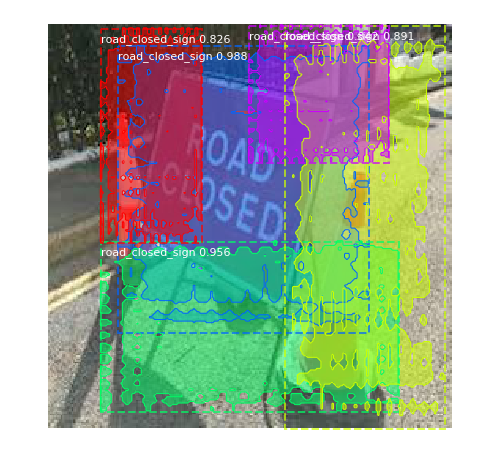

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

**Evaluation**

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox[:,:4], gt_bbox[:,4],
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)

print("mAP: ", np.mean(APs))

mAP:  0.475


## Filter detections

In [ ]:
# Filter detections that belong to validation images
detections = filter_val_detections(detections)

In [ ]:
# (0,32) (32,46) (46,1000)
detections_small = filter_detections_by_width(detections, 0, 32)
detections_medium = filter_detections_by_width(detections, 32, 46)
detections_large = filter_detections_by_width(detections, 46, 1000)

Pred bbox num 0 of image 00639.jpg was not removed
89
Pred bbox num 0 of image 00639.jpg was not removed
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 1 of image 00787.jpg was not removed
Pred bbox num 0 of image 00864.jpg was not removed
Pred bbox num 0 of image 00868.jpg was not removed
Pred bbox num 1 of image 00868.jpg was not removed
93
Pred bbox num 0 of image 00650.jpg was not removed
Pred bbox num 1 of image 00787.jpg was not removed
Pred bbox num 0 of image 00864.jpg was not removed
Pred bbox num 0 of image 00868.jpg was not removed
Pred bbox num 1 of image 00868.jpg was not removed
91


In [ ]:
print(detections[0])

{'file': '00624.jpg', 'gt_classes': [2, 1], 'pred_classes': [2, 1], 'pred_bboxes': [(387.6166534423828, 505.2435874938965, 434.12413120269775, 553.7459373474121), (820.5635166168213, 463.40880393981934, 844.9479532241821, 487.5168800354004)], 'file_path': '/media/arcos/Shared/Datasets/GermanTSDataset/Detection/00624.jpg', 'confidences': [0.99999785, 0.99996483], 'gt_bboxes': [(387, 505, 434, 554), (821, 464, 845, 488)]}


## Eval VOC Pascal 2010+

IoU threshold set to: 0.50
TP: 161.0
FP: 5.0
FN: 0.0
Avg. overlap for prohibitory = 0.9137
Precision for prohibitory = 0.9699
Recall for prohibitory = 1.0000
AP for prohibitory = 1.0000


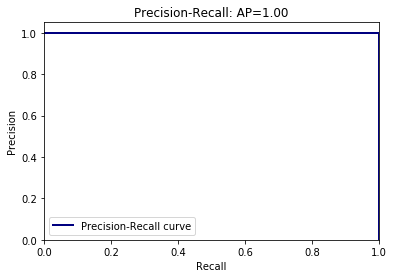

IoU threshold set to: 0.50
TP: 46.0
FP: 12.0
FN: 3.0
Avg. overlap for mandatory = 0.8916
Precision for mandatory = 0.7931
Recall for mandatory = 0.9388
AP for mandatory = 0.9366


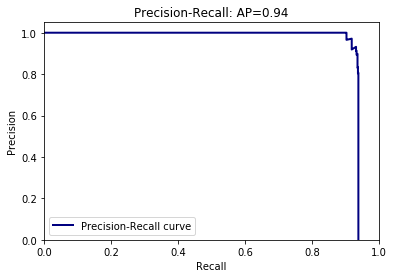

IoU threshold set to: 0.50
TP: 59.0
FP: 5.0
FN: 4.0
Avg. overlap for danger = 0.9011
Precision for danger = 0.9219
Recall for danger = 0.9365
AP for danger = 0.9365


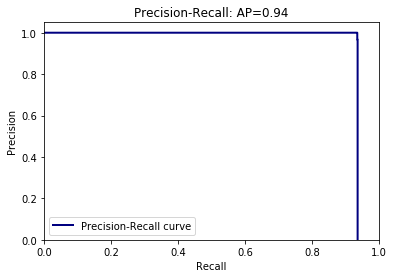

Mean AP = 0.9577
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.969880  1.000000  1.000000
1    mandatory   0.793103  0.938776  0.936559
2       danger   0.921875  0.936508  0.936474


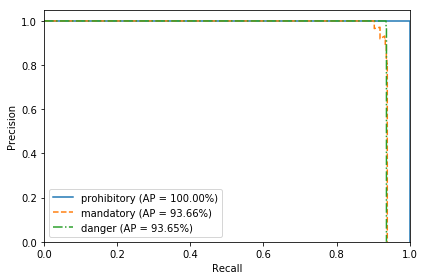

----- Small detections -----
IoU threshold set to: 0.50
TP: 53.0
FP: 9.0
FN: 4.0
Avg. overlap for prohibitory = 0.8872
Precision for prohibitory = 0.8548
Recall for prohibitory = 0.9298
AP for prohibitory = 0.8818


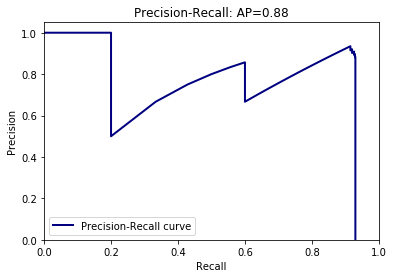

IoU threshold set to: 0.50
TP: 19.0
FP: 12.0
FN: 3.0
Avg. overlap for mandatory = 0.8446
Precision for mandatory = 0.6129
Recall for mandatory = 0.8636
AP for mandatory = 0.8490


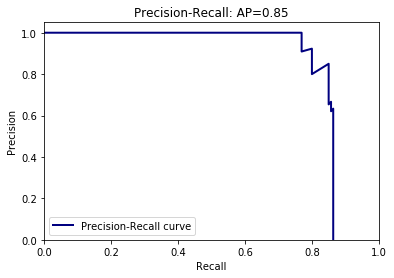

IoU threshold set to: 0.50
TP: 5.0
FP: 7.0
FN: 5.0
Avg. overlap for danger = 0.8175
Precision for danger = 0.4167
Recall for danger = 0.5000
AP for danger = 0.3272


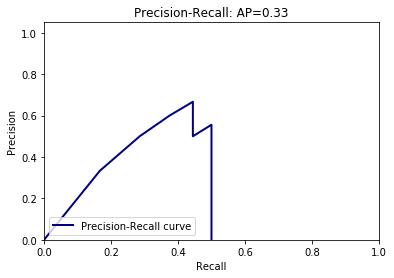

Mean AP = 0.6860
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.854839  0.929825  0.881834
1    mandatory   0.612903  0.863636  0.849008
2       danger   0.416667  0.500000  0.327160


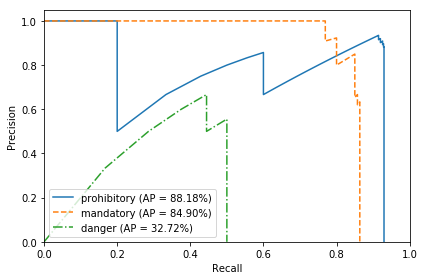

----- Medium detections -----
IoU threshold set to: 0.50
TP: 59.0
FP: 9.0
FN: 5.0
Avg. overlap for prohibitory = 0.9119
Precision for prohibitory = 0.8676
Recall for prohibitory = 0.9219
AP for prohibitory = 0.9184


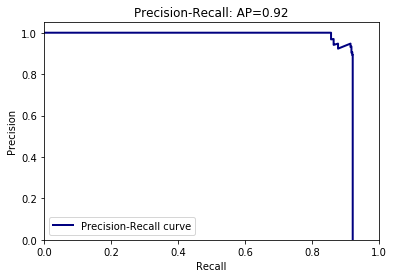

IoU threshold set to: 0.50
TP: 13.0
FP: 11.0
FN: 1.0
Avg. overlap for mandatory = 0.9060
Precision for mandatory = 0.5417
Recall for mandatory = 0.9286
AP for mandatory = 0.9273


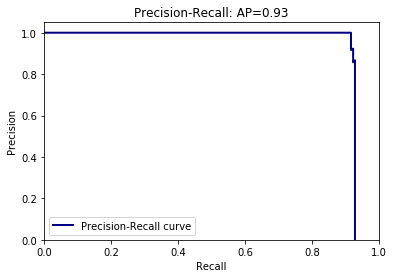

IoU threshold set to: 0.50
TP: 13.0
FP: 9.0
FN: 2.0
Avg. overlap for danger = 0.8812
Precision for danger = 0.5909
Recall for danger = 0.8667
AP for danger = 0.7528


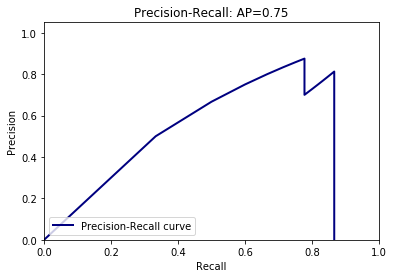

Mean AP = 0.8662
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.867647  0.921875  0.918428
1    mandatory   0.541667  0.928571  0.927346
2       danger   0.590909  0.866667  0.752778


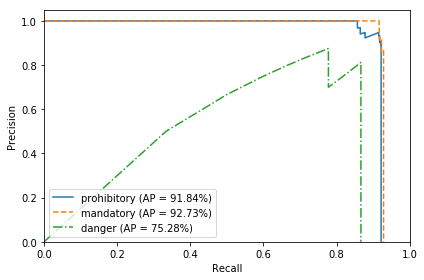

----- Large detections -----
IoU threshold set to: 0.50
TP: 36.0
FP: 10.0
FN: 4.0
Avg. overlap for prohibitory = 0.9474
Precision for prohibitory = 0.7826
Recall for prohibitory = 0.9000
AP for prohibitory = 0.8723


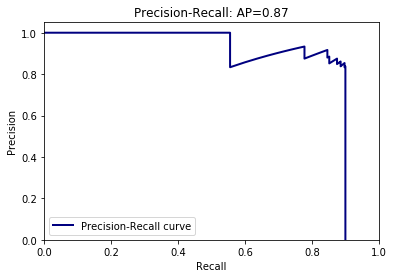

IoU threshold set to: 0.50
TP: 12.0
FP: 13.0
FN: 1.0
Avg. overlap for mandatory = 0.9471
Precision for mandatory = 0.4800
Recall for mandatory = 0.9231
AP for mandatory = 0.6695


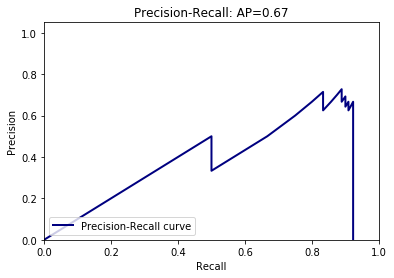

IoU threshold set to: 0.50
TP: 35.0
FP: 5.0
FN: 3.0
Avg. overlap for danger = 0.9199
Precision for danger = 0.8750
Recall for danger = 0.9211
AP for danger = 0.9211


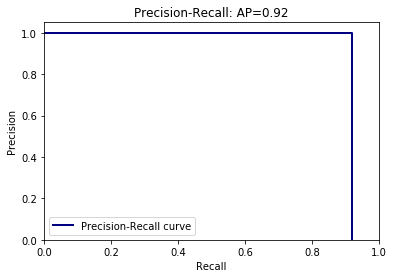

Mean AP = 0.8210
~~~~~~~~
Results:
         class  precision    recall        ap
0  prohibitory   0.782609  0.900000  0.872315
1    mandatory   0.480000  0.923077  0.669542
2       danger   0.875000  0.921053  0.921053


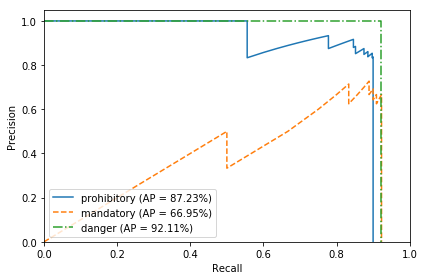

0.8209698449323071

In [ ]:
compute_mean_average_precision(detections)
print("----- Small detections -----")
compute_mean_average_precision(detections_small)
print("----- Medium detections -----")
compute_mean_average_precision(detections_medium)
print("----- Large detections -----")
compute_mean_average_precision(detections_large)